In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg.interpolative as sli
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from time import perf_counter
from scipy.io import mmread
from PIL import Image
import glob

In [2]:
rng = np.random.default_rng()

## Define low-rank approximations

### SVD

In [3]:
def svd(A, k):
    """Computes the optimal deterministic rank-k approximation of the SVD of the input matrix."""
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    Sigma = np.diag(sigma[:k])
    return U[:,:k] @ Sigma @ Vh[:k], None, None

### Optimized ID

In [4]:
def optim_id(A, k):
    """Computes a rank-k ID approximation using an optimized least-squares solver."""
    
    # if A is (m,n) with m <= n, then Q is (m,m), R is (m,n), and P is (n,)
    Q, R, P = scipy.linalg.qr(A, pivoting=True, mode='economic', check_finite=False)

    Q_k = Q[:,:k]
    R_k = R[:k,:k]
    cols = P[:k]
    
    C = A[:,cols]
    
    try:
        Z = scipy.linalg.solve(R_k.T @ R_k, C.T @ A, overwrite_a=True, overwrite_b=True, assume_a='pos')
    except np.linalg.LinAlgError:
        data_rank = np.linalg.matrix_rank(A)
        raise ValueError(f"Invalid input: rank of data ({data_rank}) is less than requested rank of approximation ({k}).")

    approx = C @ Z

    return approx, cols, Z

### Optimized RID

In [5]:
def _optim_rid(A, k, oversampling=10):
    """Computes a randomized rank-k ID approximation using an optimized least-squares solver."""
    
    if oversampling < 0:
        raise ValueError('Oversampling parameter cannot be negative.')
        
    p = k + oversampling
    if p > A.shape[1]:
        raise ValueError('Oversampling parameter is too large.')
    
    idx = rng.choice(A.shape[1], replace=False, size=p)
    AS = A[:,idx]
    
    # if AS is (m,p) with m >= p, then Q is (m,p), R is (p,p), and P is (p,)
    Q, R, P = scipy.linalg.qr(AS, pivoting=True, mode='economic', check_finite=False)

    Q_k = Q[:,:k]  # removes the p-k oversampled columns
    R_k = R[:k,:k]
    _cols = P[:k]
    cols = idx[_cols]
    
    C = AS[:,_cols]
    # because rank(AS) may be < k, we use 'sym' instead of 'pos'
    Z = scipy.linalg.solve(R_k.T @ R_k, C.T @ A, overwrite_a=True, overwrite_b=True, assume_a='sym')
    approx = C @ Z
    
    return approx, cols, Z

In [6]:
def optim_rid(A, k):
    o = int(0.2 * k)
    return _optim_rid(A, k, oversampling=o)

### Optim ID triangular variant

Instead of using the Cholesky method through the SciPy positive-definite linear solver, we use back substitution through the SciPy triangular solver. This is the same technique that SciPy ID uses.

In [7]:
def optim_id_tri(A, k):
    """Computes a rank-k ID approximation using an optimized least-squares solver."""
    
    # if A is (m,n) with m <= n, then Q is (m,m), R is (m,n), and P is (n,)
    _, R, P = scipy.linalg.qr(A, pivoting=True, mode='economic', check_finite=False)
    
    _, n = A.shape
    P_mat = np.identity(n)[:,P]

    R_k = R[:k,:k]
    cols = P[:k]
    
    C = A[:,cols]
    
    try:
        Z = scipy.linalg.solve_triangular(R_k, R[:k] @ P_mat.T, overwrite_b=True, check_finite=False)
    except np.linalg.LinAlgError:
        data_rank = np.linalg.matrix_rank(A)
        raise ValueError(f"Invalid input: rank of data ({data_rank}) is less than requested rank of approximation ({k}).")

    approx = C @ Z

    return approx, cols, Z

### SciPy ID

In [8]:
def scipy_id_main(A, k, randomized):
    idx, proj = sli.interp_decomp(A, k, rand=randomized)
    cols = idx[:k]
    C = A[:,cols]
    Z = sli.reconstruct_interp_matrix(idx, proj)
    approx = np.dot(C, Z)
    return approx, cols, Z

def scipy_id(A, k):
    return scipy_id_main(A, k, randomized=False)

def scipy_random_id(A, k):
    return scipy_id_main(A, k, randomized=True)

## Initialize data

In [9]:
def get_data(string):
    m = 784
    n = 1000
    dims = (m,n)
    
#     if string == "low-rank":
#         mat1 = rng.standard_normal(size=(m,100))
#         mat2 = rng.standard_normal(size=(100,n))
#         data = mat1 @ mat2
    if string == "boolean":
        data = rng.integers(1, size=dims, endpoint=True)
        data = data.astype(np.float64, copy=False)
    elif string == "gaussian":
        data = rng.standard_normal(size=dims)
    elif string == "uniform":
        data = rng.uniform(size=dims)
    elif string == "mnist":
        mnist = pd.read_csv('../datasets/mnist/train.csv')
        data = mnist[mnist.columns[1:]].values / 255
        data = data[:5000]
    elif string == "fashion-mnist":
        mnist = pd.read_csv('../datasets/fashion-mnist/train.csv')
        data = mnist[mnist.columns[1:]].values / 255
        data = data[:5000]
    elif string == "lfw":
        data = np.empty((187500, 100))
        for i,filename in enumerate(glob.iglob('../datasets/lfw/**/*.jpg', recursive = True)):
            if i >= 100:
                break
            im=Image.open(filename)
            data[:,i] = np.asarray(im).flatten() / 255
            im.close()
    elif string == "sparse1":
        data = pd.read_csv('../datasets/sparse/testsparse.csv').values
    elif string == "sparse2":
        data = np.asarray(mmread('../datasets/sparse/Vehicle_10NN.mtx').todense())
    elif string == "sparse3": 
        data = np.asarray(mmread('../datasets/sparse/Spectro_10NN.mtx').todense())
    else:
        raise ValueError("Dataset not found!")
    
    
    # make matrix 'wide' not 'tall'
    if data.shape[0] > data.shape[1]:
        data = data.T
    
    return data

In [10]:
data = get_data("gaussian")

In [11]:
data.shape

(784, 1000)

In [12]:
np.linalg.matrix_rank(data)

784

## Numerical experiments

### setup

In [13]:
def calculate_error(A):
    return np.linalg.norm(data - A) / np.linalg.norm(data)

In [14]:
def check_columns(dcols, acols, name):
    if np.allclose(dcols, acols):
        return
    if np.allclose(dcols, acols, atol=3e-08):
        print(f"{name} columns warning -- max entry-wise error: {np.max(np.abs(dcols - acols))}")
        return
    raise ValueError(f"{name}: columns not preserved!")

In [15]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [16]:
k_domain = np.arange(10, 490, step=20)
k_len = k_domain.shape[0]

In [17]:
ITERATIONS = 10

### deterministic methods

In [18]:
DET_ID_ALGS = [scipy_id, optim_id, optim_id_tri]
DET_ALGS = [svd] + DET_ID_ALGS
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, k_len))
DET_TIMES = np.empty((num_det_algs, k_len))
DET_MAX_ENTRY = np.empty((num_det_algs-1, k_len))


for i, k in enumerate(tqdm(k_domain)):
    for h, alg in enumerate(tqdm(DET_ALGS, leave=False)):
        start = perf_counter()
        approx, cols, Z = alg(data, k)
        end = perf_counter()
        
        DET_TIMES[h,i] = end - start
        DET_ERRORS[h,i] = calculate_error(approx)
        
        if alg == svd:
            continue
        
        check_columns(data[:,cols], approx[:,cols], alg.__name__)
        DET_MAX_ENTRY[h-1,i] = np.max(np.abs(Z))

### randomized methods

In [20]:
RAND_ALGS = [scipy_random_id, optim_rid]
num_rand_algs = len(RAND_ALGS)

RAND_ERRORS = np.empty((num_rand_algs, 7, k_len))
RAND_TIMES = np.empty((num_rand_algs, 7, k_len))
RAND_MAX_ENTRY = np.empty((num_rand_algs, 7, k_len))


for i, k in enumerate(tqdm(k_domain)):
    errors = np.empty((num_rand_algs, ITERATIONS))
    times = np.empty((num_rand_algs, ITERATIONS))
    max_entry = np.empty((num_rand_algs, ITERATIONS))

    for j in trange(ITERATIONS, leave=False):
        for h, alg in enumerate(RAND_ALGS):
            start = perf_counter()
            approx, cols, Z = alg(data, k)
            end = perf_counter()
            
            times[h,j] = end - start
            errors[h,j] = calculate_error(approx)
            check_columns(data[:,cols], approx[:,cols], alg.__name__)
            max_entry[h,j] = np.max(np.abs(Z))
        
    for h in range(num_rand_algs):
        RAND_ERRORS[h,:,i] = stats(errors[h])
        RAND_TIMES[h,:,i] = stats(times[h])
        RAND_MAX_ENTRY[h,:,i] = stats(max_entry[h])

## Display results

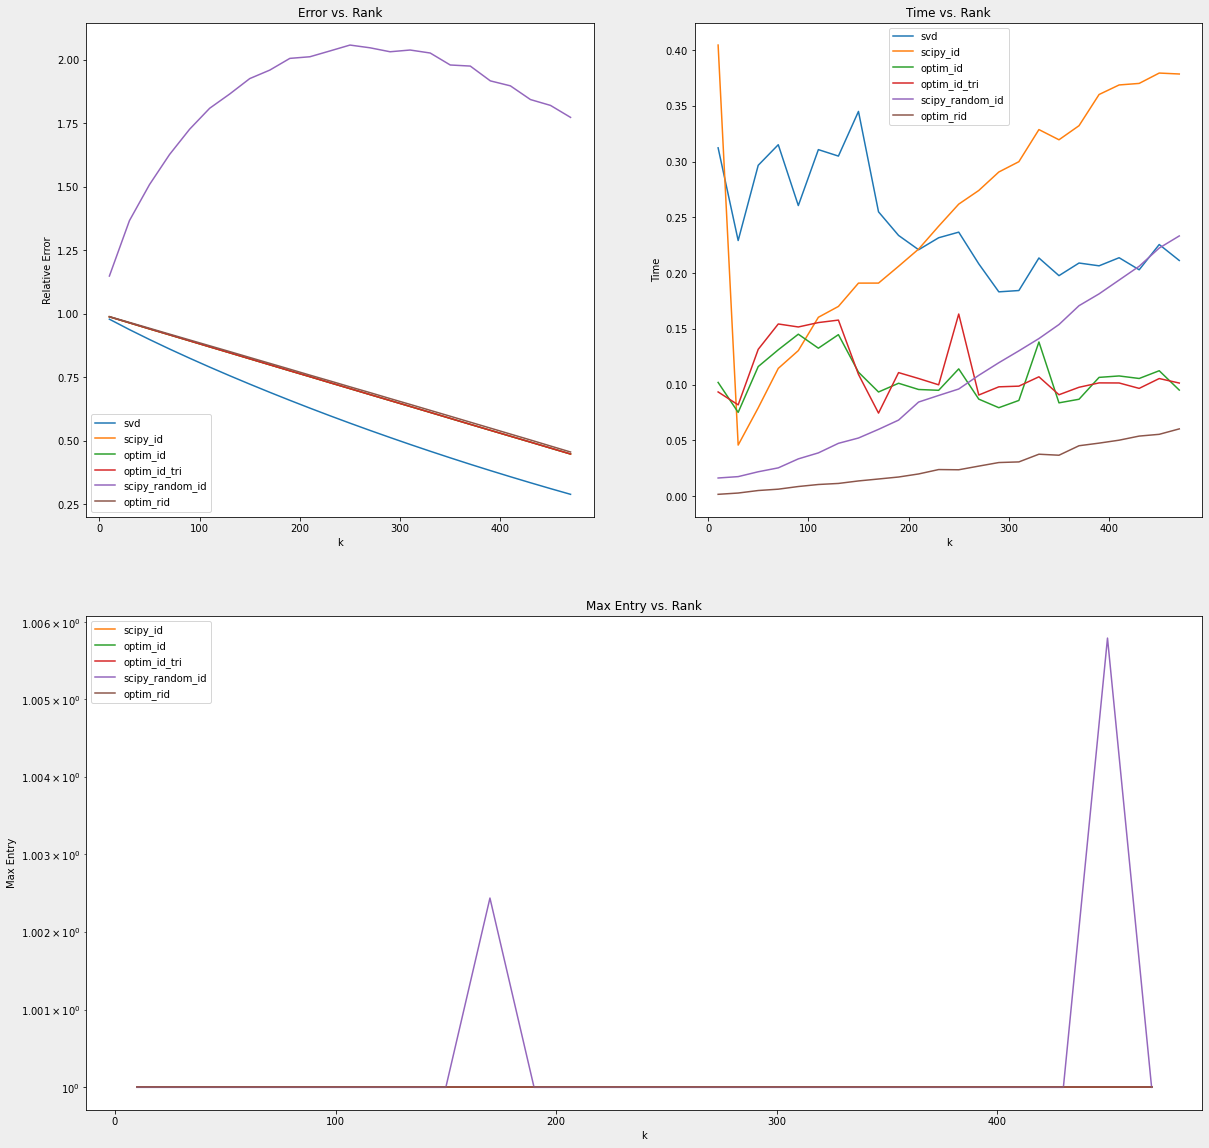

In [21]:
fig = plt.figure(figsize=(20,20))
fig.set_facecolor('#EEE')
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
axs = [ax1, ax2, ax3]



# ERROR GRAPH
idx = 0
for h, alg in enumerate(DET_ALGS):
    axs[idx].plot(k_domain, DET_ERRORS[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    axs[idx].plot(k_domain, RAND_ERRORS[h,3], label=alg.__name__)

axs[idx].set_xlabel('k')
axs[idx].set_ylabel('Relative Error')
axs[idx].legend(loc='best')
axs[idx].set_title('Error vs. Rank')


# TIME GRAPH
idx = 1
for h, alg in enumerate(DET_ALGS):
    axs[idx].plot(k_domain, DET_TIMES[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    axs[idx].plot(k_domain, RAND_TIMES[h,3], label=alg.__name__)

axs[idx].set_xlabel('k')
axs[idx].set_ylabel('Time')
# axs[idx].set_yscale('log')
axs[idx].legend(loc='best')
axs[idx].set_title('Time vs. Rank')


# MAX ENTRY GRAPH
idx = 2
axs[idx].plot([], [])  # null plot to advance color cycler to stay in sync with previous plots
for h, alg in enumerate(DET_ID_ALGS):
    axs[idx].plot(k_domain, DET_MAX_ENTRY[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    axs[idx].plot(k_domain, RAND_MAX_ENTRY[h,3], label=alg.__name__)

axs[idx].set_xlabel('k')
axs[idx].set_ylabel('Max Entry')
axs[idx].set_yscale('log')
axs[idx].legend(loc='best')
axs[idx].set_title('Max Entry vs. Rank');